# Performance comparison against Lenstronomy

The notebook compares `helens` to the lens equation solvers implemented in `lenstronomy`. It also gives runtime for high-resolution lensed quasar image simulation, using `herculens` and `lenstromomy` features.

__authors__: @aymgal, @austinpeel

__last update__: 29/02/24

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none', origin='lower')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
from pprint import pprint
from astropy.io import fits

# JAX-related
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.PointSourceModel.point_source_model import PointSourceModel  # this imports the `helens` solver
from herculens.LensImage.lens_image import LensImage
from herculens.Util import plot_util

# Lenstronomy
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel as LightModel_lenstronomy
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.psf import PSF as PSF_lenstronomy
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util

/Users/aymgal/miniconda3/envs/herculens39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


USING ORIGINAL SOLVER


/Users/aymgal/miniconda3/envs/herculens39/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
# to quickly change the source position and rerun the notebook
SOURCE_POSITION = (-0.02, -0.11)

## Common setup between the two codes

In [3]:
# Einstein radius
theta_E = 1.16
# powerlaw slope
gamma = 2.09
# position of the lens
cx0, cy0 = 0.09, -0.04
# position angle, here in degree
phi = 52.
# axis ratio, b/a
q = 0.74
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180., q)
# external shear orientation, here in degree
phi_ext = 5.0
# external shear strength
gamma_ext = 0.1
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180., gamma_ext)
kwargs_lens_input = [
    {'theta_E': theta_E, 'gamma': gamma, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]

# Lens light
kwargs_lens_light_input = [
    {'amp': 50., 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]

# Source light
source_pos = SOURCE_POSITION
kwargs_source_input = [
    {'amp': 50., 'R_sersic': 0.1, 'e1': 0.1, 'e2': -0.04, 'n_sersic': 2.7, 'center_x': source_pos[0], 'center_y': source_pos[1]}
]

# Quasar (point source) light
quasar_amp = 10.
quasar_pos = source_pos

# PSF
psf_kernel_file = f"psf_kernel_NIRCam_F444W_STARRED_super1.fits"
psf_kernel = fits.getdata(os.path.join("data", psf_kernel_file), header=False)
psf_kernel = psf_kernel.astype(np.float64)
psf_kernel /= psf_kernel.sum()

# Observation
npix = 160  # number of pixel on a side
pix_scl = 0.03  # pixel size in arcsec
# exposure time, used for estimating the shot noise
exp_time = 2000.  # seconds
# standard deviation of the background noise
sigma_bkg = 0.005  # electrons/second

# Coordinate grid
half_size = npix * pix_scl / 2.
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2.  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle

# General numerics
supersampling_factor = 3

## Image models comparison

### Herculens model

In [4]:
# create the PixelGrid class
pixel_grid = PixelGrid(
    nx=npix, ny=npix,
    ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0,
    transform_pix2angle=transform_pix2angle,
)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

# print(f"image size : ({npix}, {npix}) pixels")
# print(f"pixel size : {pix_scl} arcsec")
# print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
# print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

psf = PSF(
    psf_type='PIXEL',
    kernel_point_source=psf_kernel,
)

noise = Noise(
    npix, npix,
    background_rms=sigma_bkg,
    exposure_time=exp_time,
)

# Create a pixel grid for solving the lens equation with possibly different resolution
ps_grid = pixel_grid.create_model_grid(pixel_scale_factor=0.5)

# Model components
lens_mass_model_input = MassModel(['EPL', 'SHEAR'])
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
source_model_input = LightModel(['SERSIC_ELLIPSE'])
point_source_model_input = PointSourceModel(
    ['SOURCE_POSITION'], mass_model=lens_mass_model_input, image_plane=ps_grid
)

# Solver hyperparameters
niter_solver = 5
triangle_scale_factor = 2
n_triangle_subdivisions = 3
kwargs_lens_equation_solver = {
    'nsolutions': 5, 
    'niter': niter_solver, 
    'scale_factor': triangle_scale_factor, 
    'nsubdivisions': n_triangle_subdivisions,
}

# Generate a lensed image based on source and lens models
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                        lens_mass_model_class=lens_mass_model_input,
                        source_model_class=source_model_input,
                        lens_light_model_class=lens_light_model_input,
                        point_source_model_class=point_source_model_input,
                        kwargs_numerics=dict(supersampling_factor=supersampling_factor),
                        kwargs_lens_equation_solver=kwargs_lens_equation_solver)

# Wrap up parameters values
all_kwargs_herculens = dict(
    kwargs_lens=kwargs_lens_input,
    kwargs_source=kwargs_source_input,
    kwargs_lens_light=kwargs_lens_light_input,
    kwargs_point_source=[{'ra': quasar_pos[0], 'dec': quasar_pos[1], 'amp': quasar_amp}],
)

@jax.jit
def simulate_herculens(all_kwargs):    
    # Clean image
    model = lens_image.model(**all_kwargs)
    # Simulation including noise
    simulation = lens_image.simulation(
        **all_kwargs,
        prng_key=jax.random.PRNGKey(42),
    )
    return model, simulation

### Lenstronomy model

In [5]:
kwargs_data = sim_util.data_configure_simple(npix, pix_scl, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF_lenstronomy(**kwargs_psf)
lens_model_class = LensModel(['EPL', 'SHEAR'])
sersic_major_axis = True  # in order to be compared to Herculens convention
lens_light_model_class = LightModel_lenstronomy(['SERSIC_ELLIPSE'], sersic_major_axis=sersic_major_axis)
source_model_class = LightModel_lenstronomy(['SERSIC_ELLIPSE'], sersic_major_axis=sersic_major_axis)
point_source_class = PointSource(['LENSED_POSITION'])
lensEquationSolver = LensEquationSolver(lens_model_class)

# Input values
all_kwargs_lenstronomy_no_ps = dict(
    kwargs_lens=kwargs_lens_input,
    kwargs_source=kwargs_source_input,
    kwargs_lens_light=kwargs_lens_light_input,
)

np.random.seed(42)

def simulate_lenstronomy(all_kwargs_no_ps, eq_solver_type='default'):
    if eq_solver_type == 'default':
        ra_image, dec_image = lensEquationSolver.findBrightImage(quasar_pos[0], quasar_pos[1], kwargs_lens_input, numImages=5,
                                                                min_distance=pix_scl, search_window=npix * pix_scl)
    elif eq_solver_type == 'stochastic':
        ra_image, dec_image = lensEquationSolver.image_position_from_source(
            quasar_pos[0], quasar_pos[1], kwargs_lens_input, 
            solver="stochastic",
            search_window=npix*pix_scl,
            precision_limit=1e-10,
        )
    elif eq_solver_type == 'analytical':
        ra_image, dec_image = lensEquationSolver.image_position_from_source(
            quasar_pos[0], quasar_pos[1], kwargs_lens_input, 
            solver="analytical",
        )

    # compute lensing magnification at image positions
    mag = lens_model_class.magnification(ra_image, dec_image, kwargs=kwargs_lens_input)
    point_amp = quasar_amp * np.abs(mag)
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                            lens_light_model_class,
                            point_source_class, 
                            kwargs_numerics=dict(supersampling_factor=supersampling_factor))

    model = imageModel.image( 
        kwargs_ps=[{'ra_image': ra_image, 'dec_image': dec_image, 'point_amp': point_amp}],
        **all_kwargs_no_ps,
    )
    poisson = image_util.add_poisson(model, exp_time=exp_time)
    bkg = image_util.add_background(model, sigma_bkd=sigma_bkg)
    simulation = model + bkg + poisson
    return model, simulation

/Users/aymgal/Science/packages/forked/lenstronomy_forked/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


## Point source positions comparison

In [6]:
# Lenstronomy, default solver
ra_img_lenstronomy, dec_img_lenstronomy = lensEquationSolver.findBrightImage(
    quasar_pos[0], quasar_pos[1], kwargs_lens_input, numImages=5,
    min_distance=pix_scl, search_window=npix * pix_scl
)

# Lenstronomy, analytical solver for EPL+shear models
ra_img_analytical, dec_img_analytical = lensEquationSolver.image_position_from_source(
    quasar_pos[0], quasar_pos[1], kwargs_lens_input, 
    solver="analytical",
)

# Herculens
ra_img_herculens, dec_img_herculens, amp_img_herculens = point_source_model_input.get_multiple_images(
    [{'ra': quasar_pos[0], 'dec': quasar_pos[1], 'amp': quasar_amp}], 
    kwargs_lens=kwargs_lens_input,
    kwargs_solver=kwargs_lens_equation_solver, k=None, with_amplitude=True,
    zero_amp_duplicates=True, re_compute=False
)

ra_img_herculens = np.array(ra_img_herculens[0])
dec_img_herculens = np.array(dec_img_herculens[0])
amp_img_herculens = np.array(amp_img_herculens[0])

# we then sort (here according to x coord)
sort_indices_l = np.argsort(ra_img_lenstronomy)
ra_img_lenstronomy = ra_img_lenstronomy[sort_indices_l]
dec_img_lenstronomy = dec_img_lenstronomy[sort_indices_l]

sort_indices_a = np.argsort(ra_img_analytical)
ra_img_analytical = ra_img_analytical[sort_indices_a]
dec_img_analytical = dec_img_analytical[sort_indices_a]

ra_img_herculens = ra_img_herculens[amp_img_herculens > 1e-10]  # remove zero-amp images
dec_img_herculens = dec_img_herculens[amp_img_herculens > 1e-10]  # remove zero-amp images
sort_indices_h = np.argsort(ra_img_herculens)
ra_img_herculens = ra_img_herculens[sort_indices_h]
dec_img_herculens = dec_img_herculens[sort_indices_h]
print(ra_img_herculens, '\n', ra_img_lenstronomy, '\n', ra_img_analytical)
print(dec_img_herculens, '\n', dec_img_lenstronomy, '\n', dec_img_analytical)

[-1.29486068  0.17526399  0.5745761   1.02535826] 
 [-1.2948612   0.1752646   0.57457581  1.02535899] 
 [-1.2948612   0.1752646   0.57457581  1.02535899]
[-0.00270035 -1.1385888   0.81294481 -0.74353363] 
 [-0.0026997  -1.13858815  0.81294471 -0.74353354] 
 [-0.0026997  -1.13858815  0.81294471 -0.74353354]


In [7]:
# estimate precision from the Helens lens equation solver settings
# accuracy_solver = point_source_model_input.point_sources[0].solver.estimate_accuracy(
#     niter=kwargs_lens_equation_solver['niter'], 
#     scale_factor=kwargs_lens_equation_solver['scale_factor'], 
#     nsubdivisions=kwargs_lens_equation_solver['nsubdivisions'],
# )
accuracy_solver = ps_grid.pixel_width * (kwargs_lens_equation_solver['scale_factor'] / 4**kwargs_lens_equation_solver['nsubdivisions'])**(kwargs_lens_equation_solver['niter'] / 2.)
print(accuracy_solver)

2.589502372509329e-06


Image pixel size: 3.000e-02
RMS error along RA: 1.118e-06
RMS error along Dec: 9.303e-07
RMS error along radial direction: 9.614e-07
Estimated error of the Helens solver: 2.590e-06


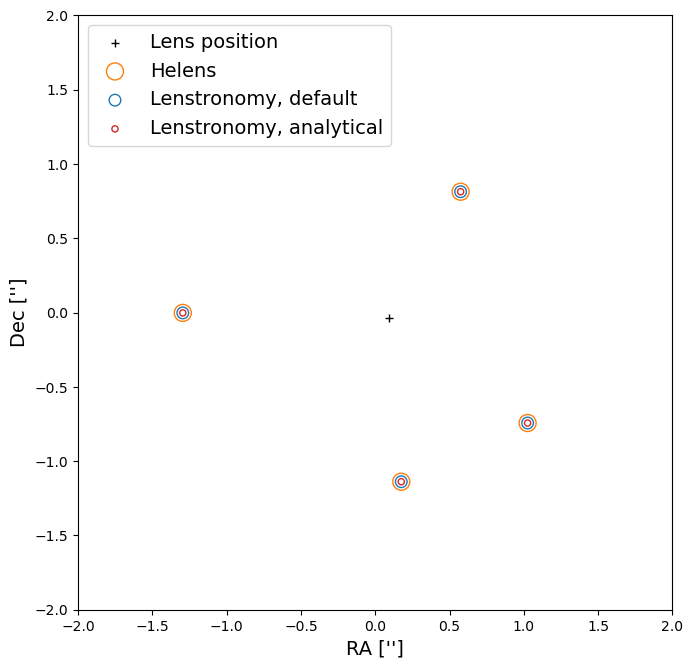

In [8]:
def rmse(v1, v2):
    return np.sqrt(np.mean(np.sum((v1 - v2)**2)))

# RMS scatter between the two codes
rms_ra = rmse(ra_img_herculens, ra_img_lenstronomy)
rms_dec = rmse(dec_img_herculens, dec_img_lenstronomy)
rms_radial = rmse(np.hypot(ra_img_herculens, dec_img_herculens), np.hypot(ra_img_lenstronomy, dec_img_lenstronomy))

print(f"Image pixel size: {pix_scl:.3e}")
print(f"RMS error along RA: {rms_ra:.3e}")
print(f"RMS error along Dec: {rms_dec:.3e}")
print(f"RMS error along radial direction: {rms_radial:.3e}")
print(f"Estimated error of the Helens solver: {accuracy_solver:.3e}")

fig, axes = plt.subplots(1, 1, figsize=(7, 7))
ax = axes
ax.scatter(cx0, cy0, s=40, marker='+', c='black', linewidths=1, label="Lens position")
ax.scatter(ra_img_herculens, dec_img_herculens, s=150, marker='o', edgecolors='tab:orange', facecolors='none', label="Helens")
ax.scatter(ra_img_lenstronomy, dec_img_lenstronomy, s=70, marker='o', edgecolors='tab:blue', facecolors='none', label="Lenstronomy, default")
ax.scatter(ra_img_analytical, dec_img_analytical, s=20, marker='o', edgecolors='tab:red', facecolors='none', label="Lenstronomy, analytical")
ax.set_xlabel("RA ['']", fontsize=14)
ax.set_ylabel("Dec ['']", fontsize=14)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(fontsize=14, loc='upper left')
fig.tight_layout()
plt.show()

## Runtime comparison

### Lenstronomy runtime

In [9]:
%%time
model_lenstronomy, sim_lenstronomy = simulate_lenstronomy(all_kwargs_lenstronomy_no_ps)

CPU times: user 95.9 ms, sys: 10.5 ms, total: 106 ms
Wall time: 106 ms


### Herculens runtime

#### Including JIT compilation time

The first time the function is executed, it is slower since it compiles it.

In [10]:
%%time
_ = simulate_herculens(all_kwargs_herculens)

CPU times: user 5.7 s, sys: 2.89 s, total: 8.59 s
Wall time: 5.02 s


#### After JIT compilation

In [11]:
%%time
model_herculens, sim_herculens = simulate_herculens(all_kwargs_herculens)

CPU times: user 78.3 ms, sys: 6.66 ms, total: 84.9 ms
Wall time: 18.1 ms


#### Convert JAX array to regular arrays

In [12]:
model_herculens, sim_herculens = np.array(model_herculens), np.array(sim_herculens)

## Image comparison

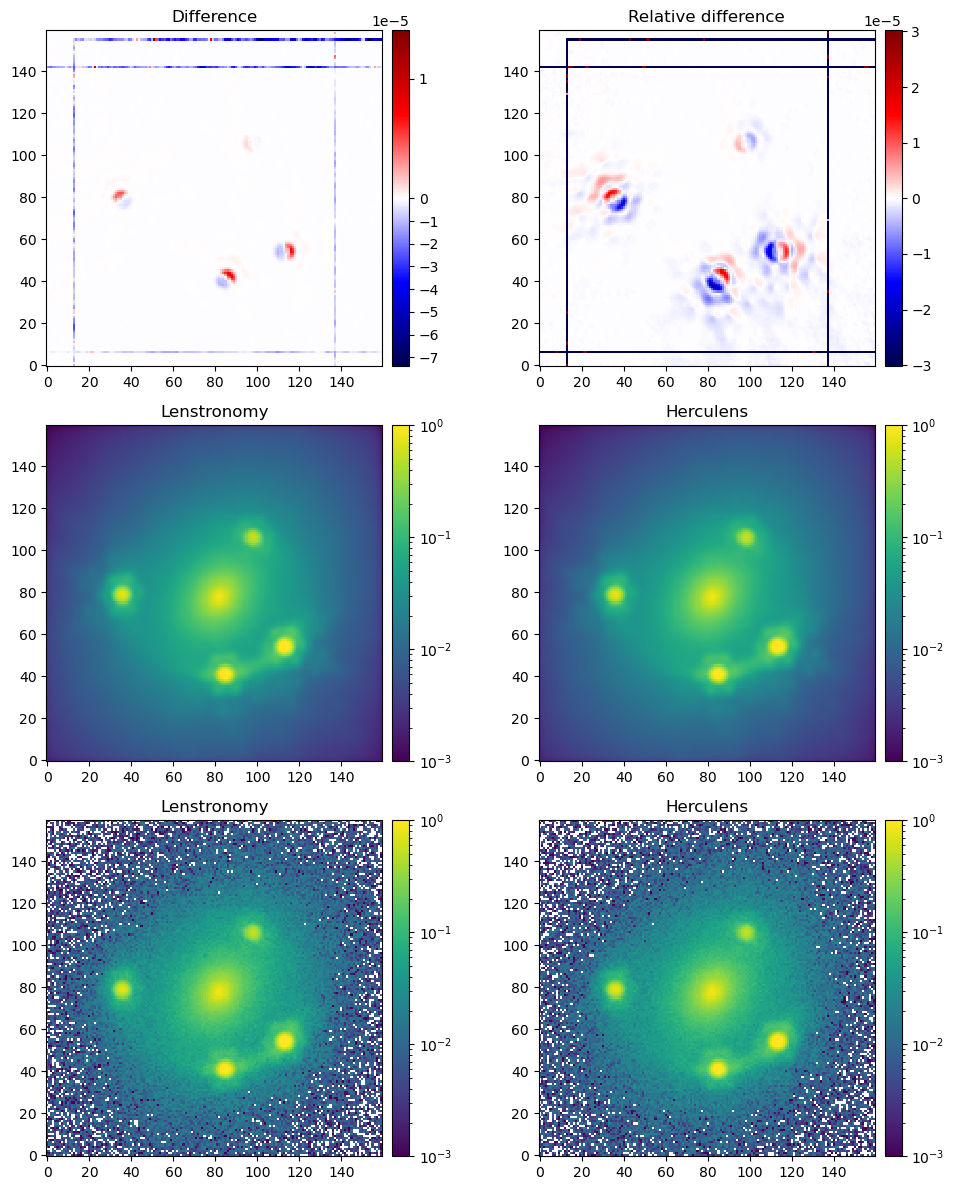

In [13]:
cmap = 'viridis'
norm = LogNorm(1e-3, 1e0)

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
ax = axes[2, 0]
im = ax.imshow(sim_lenstronomy, norm=norm, cmap=cmap)
plot_util.nice_colorbar(im)
ax.set_title("Lenstronomy")
ax = axes[2, 1]
im = ax.imshow(sim_herculens, norm=norm, cmap=cmap)
ax.set_title("Herculens")
plot_util.nice_colorbar(im)
ax = axes[1, 0]
im = ax.imshow(model_lenstronomy, norm=norm, cmap=cmap)
plot_util.nice_colorbar(im)
ax.set_title("Lenstronomy")
ax = axes[1, 1]
im = ax.imshow(model_herculens, norm=norm, cmap=cmap)
ax.set_title("Herculens")
plot_util.nice_colorbar(im)
ax = axes[0, 0]
im = ax.imshow(model_lenstronomy - model_herculens, norm=TwoSlopeNorm(0), cmap='seismic')
ax.set_title("Difference")
plot_util.nice_colorbar(im)
ax = axes[0, 1]
rel_diff = (model_lenstronomy - model_herculens) / model_lenstronomy
vmax = np.abs(rel_diff).max() * 0.001
im = ax.imshow(rel_diff, norm=Normalize(-vmax, vmax), cmap='seismic')
ax.set_title("Relative difference")
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

__Note__: "line" artifacts are caused by the the way PSF kernels are interpolated onto the pixelated grid, not the lens equation solvers. These have very low surface brightness anyway.